In [58]:
import os
import json
import plotly.graph_objs as go
import numpy as np
import regex as re 

class MetricsPlotter:
    def __init__(self, root_dir):
        self.root_dir = root_dir
    
    def read_json(self, file_path):
        with open(file_path, 'r') as file:
            return json.load(file)
            
    def sanitize_filename(self, filename):
        filename = filename.replace(' ', '_')
        filename = re.sub(r'[^\w\-_\.]', '', filename)
        return filename
        
    def get_params_string(self, params):
        summary = params.get('summary', {})
        ranking = params.get('ranking', {})
        entity = params.get('entity', {})
        relation = params.get('relation', {})

        preprocess_str = f"Preprocess: {params.get('preprocess', None)}" if params.get('preprocess', None) is not None else ''
        summary_method = f"Summary Method: {summary.get('summary_method', None)}" if summary.get('summary_method', None) is not None else ''
        summary_percentage = f"Summary Percentage: {summary.get('summary_percentage', None)}" if summary.get('summary_percentage', None) is not None else ''
        ranking_method = f"Ranking Method: {ranking.get('ranking', None)}" if ranking.get('ranking', None) is not None else ''
        ranking_perc_threshold = f"Ranking Perc Threshold: {ranking.get('ranking_perc_threshold', None)}" if ranking.get('ranking_perc_threshold', None) is not None else ''
        options_ent = f"Options Ent: {', '.join(sorted(entity.get('options_ent', [None])))}" if sorted(entity.get('options_ent', [None])) != [None] else ''
        options_rel = f"Options Rel: {', '.join(sorted(relation.get('options_rel', [None])))}" if sorted(relation.get('options_rel', [None])) != [None] else ''
        local_rm = f"Local RM: {relation.get('local_rm', None)}" if relation.get('local_rm', None) is not None else ''
        rebel_model = f"Rebel Model: {relation.get('rebel_model', None)}" if relation.get('rebel_model', None) is not None else ''        
        params_list = [preprocess_str, summary_method, summary_percentage, ranking_method, ranking_perc_threshold, options_ent, options_rel, local_rm, rebel_model]
        params_str = '\n'.join(filter(None, params_list))

        return params_str

    def plot_metrics_bar(self, json_file, save_dir, params_str):
        params_str_sanitized = self.sanitize_filename(params_str)
        
        with open(json_file) as f:
            data = json.load(f)
    
        folders = list(data.keys())
    
        rouge_metrics = {'precision': [], 'recall': [], 'f1': []}
    
        for folder, values in data.items():
            for metric, scores in values.items():
                for score_type, score_value in scores.items():
                    if metric == 'rouge-2':
                        rouge_metrics[score_type].append(score_value)
    
        barWidth = 0.2
        r = np.arange(len(folders))
    
        fig_rouge = go.Figure()
    
        labels = ['Precision', 'Recall', 'F1']
    
        for j, score_type in enumerate(['precision', 'recall', 'f1']):
            # Set fixed colors for rouge metrics
            if score_type == 'precision':
                marker_color = 'rgb(31, 119, 180)'  # Blue
            elif score_type == 'recall':
                marker_color = 'rgb(255, 127, 14)'  # Orange
            else:
                marker_color = 'rgb(44, 160, 44)'  # Green
            
            fig_rouge.add_trace(go.Bar(x=r + j * barWidth, 
                                       y=rouge_metrics[score_type], 
                                       name=f'Rouge {labels[j]}', 
                                       marker_color=marker_color))  
    
        fig_rouge.update_layout(barmode='group',
                                  xaxis_tickangle=-45,
                                  xaxis=dict(tickvals=r + barWidth * 1.5, ticktext=folders, title='Folders'),
                                  yaxis=dict(title='Scores'),
                                  title=f'\n{params_str}', 
                                  legend=dict(x=1, y=1),
                                  margin=dict(l=50, r=50, t=80, b=80),
                                  width=800,
                                  height=600,
                                  plot_bgcolor='rgba(0,0,0,0)')
    
        fig_rouge.show()
        fig_rouge.write_image(os.path.join(save_dir, f"{params_str_sanitized}_rouge.png"))  

    def plot_metrics_bar_directory(self):
        save_dir = 'plot/plot_metrics/rouge'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for root, dirs, _ in os.walk(self.root_dir):
            for dir_name in dirs:
                metrics_path = os.path.join(root, dir_name, 'metrics.json')
                params_path = os.path.join(root, dir_name, 'params.json')
    
                if all(os.path.exists(p) for p in [metrics_path, params_path]):
                    try:
                        metrics = self.read_json(metrics_path)
                        params = self.read_json(params_path)
                        params_str = self.get_params_string(params)
                        
                        self.plot_metrics_bar(metrics_path, save_dir, params_str)
                    
                    except Exception as e:
                        print(f"Error processing files in directory: {os.path.join(root, dir_name)}")
                        print(e)   

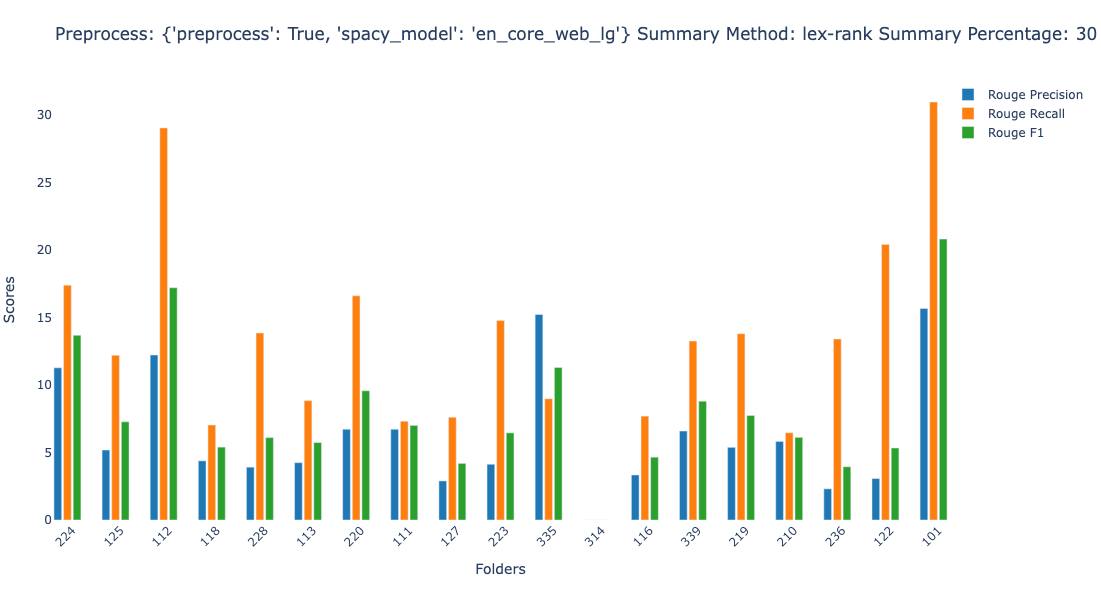

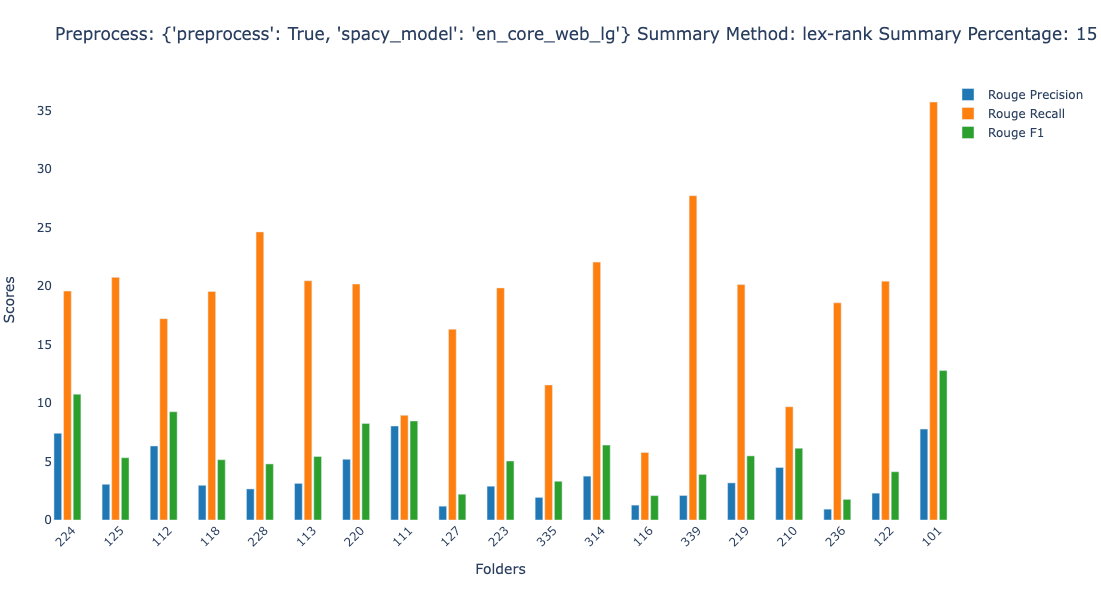

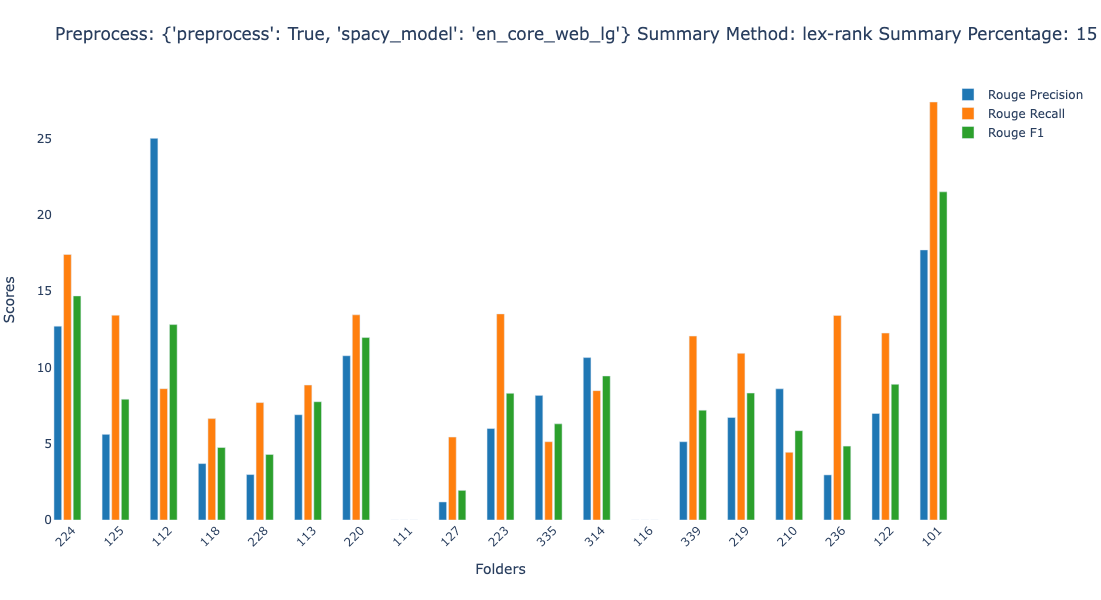

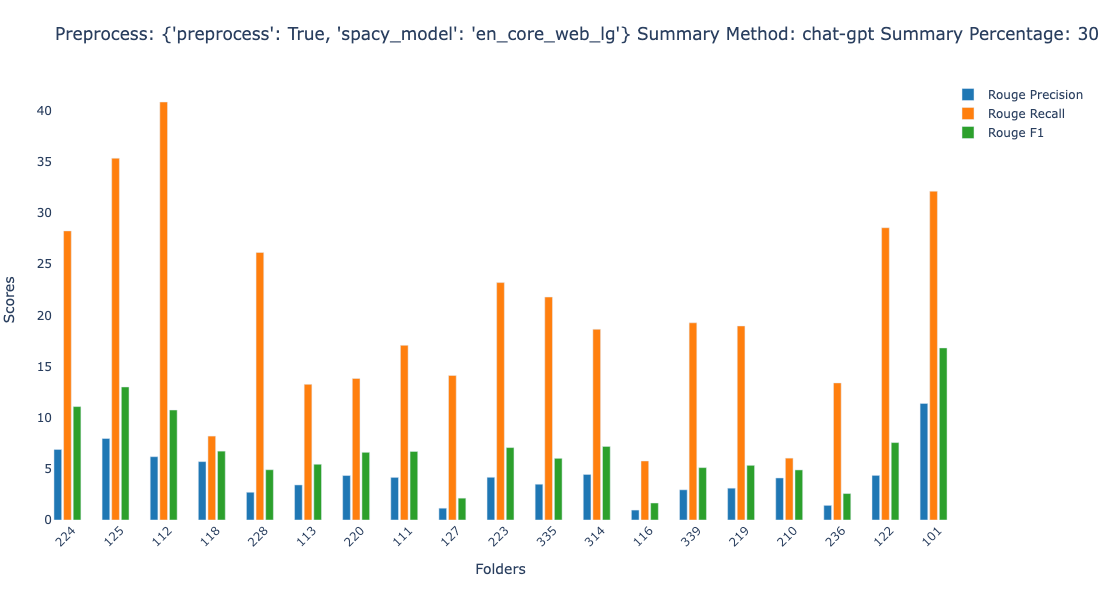

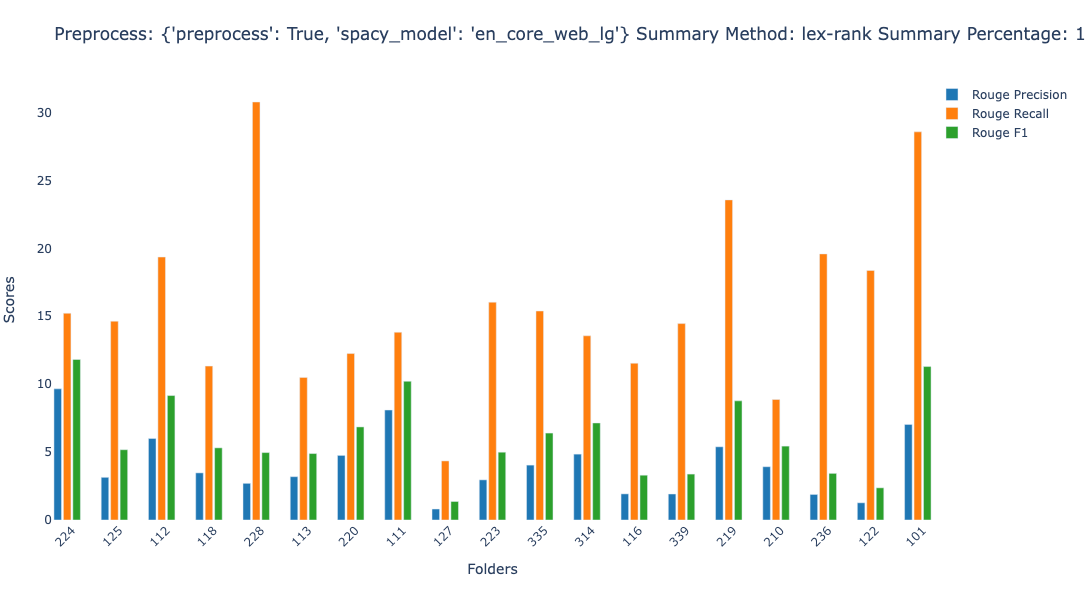

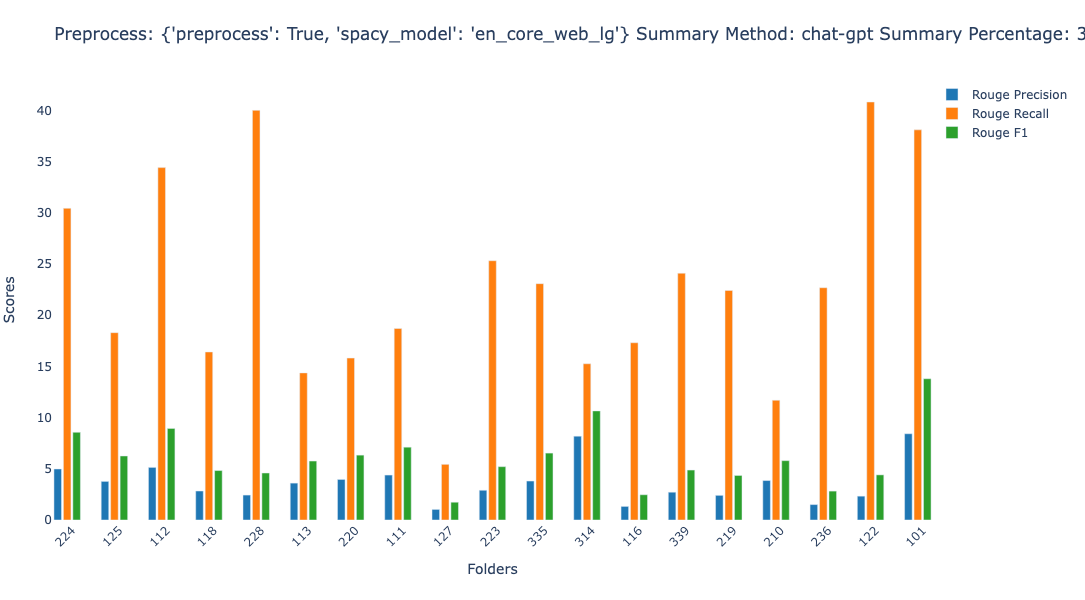

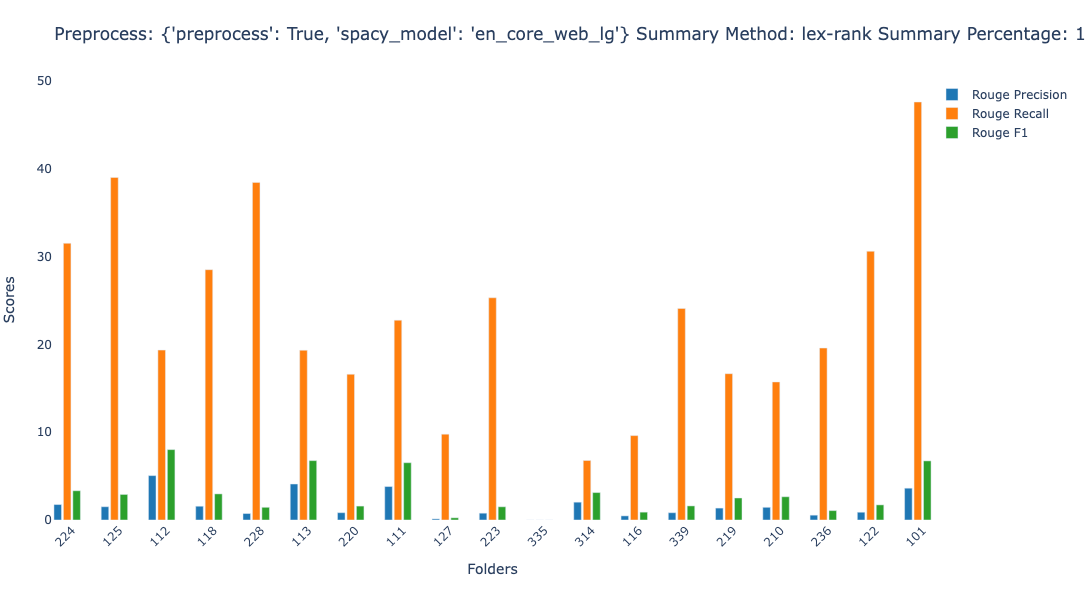

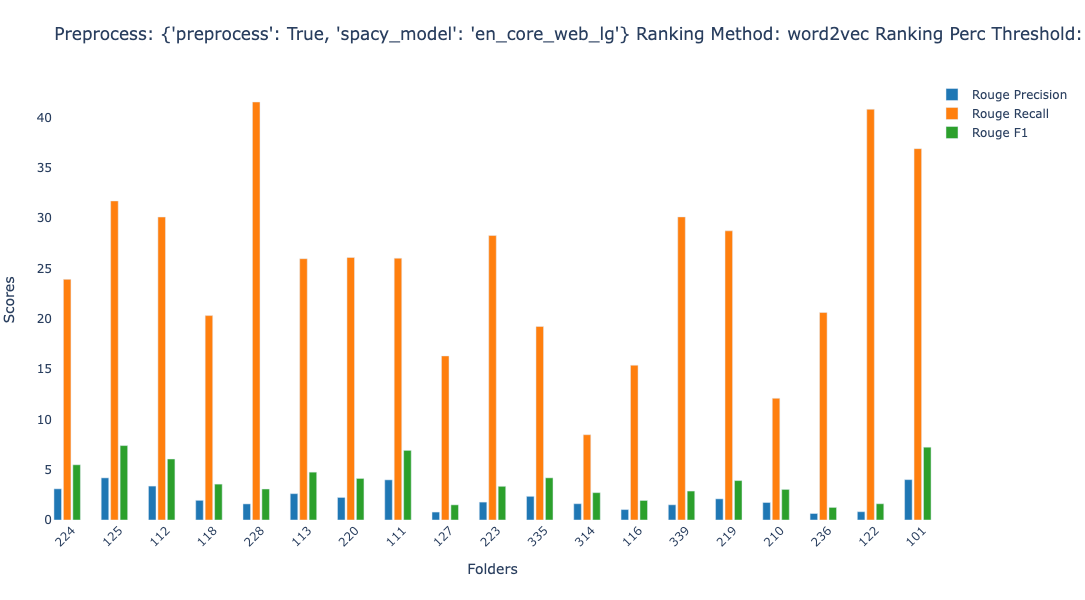

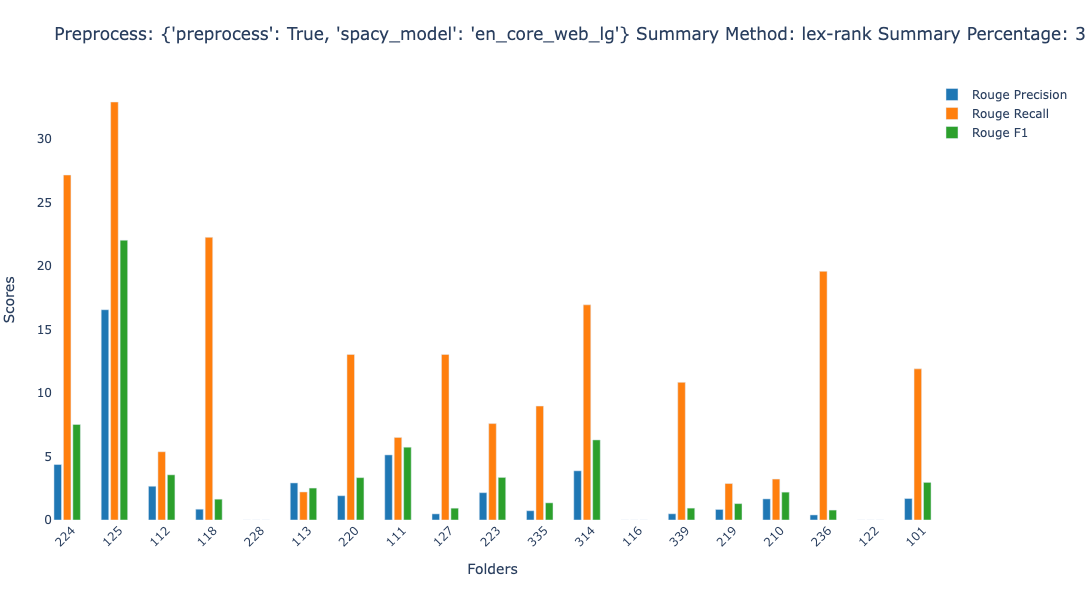

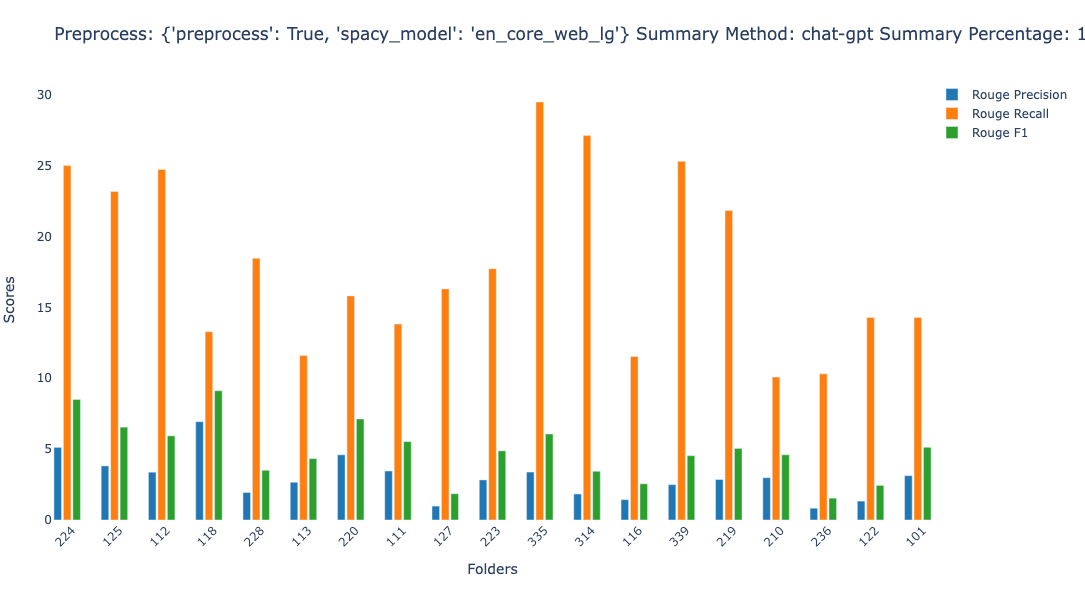

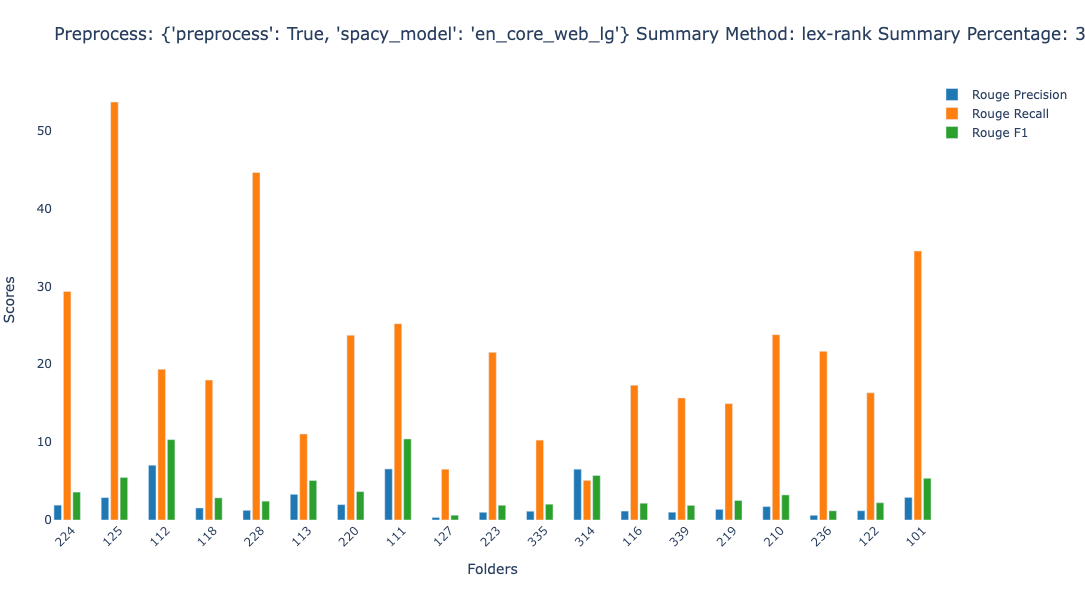

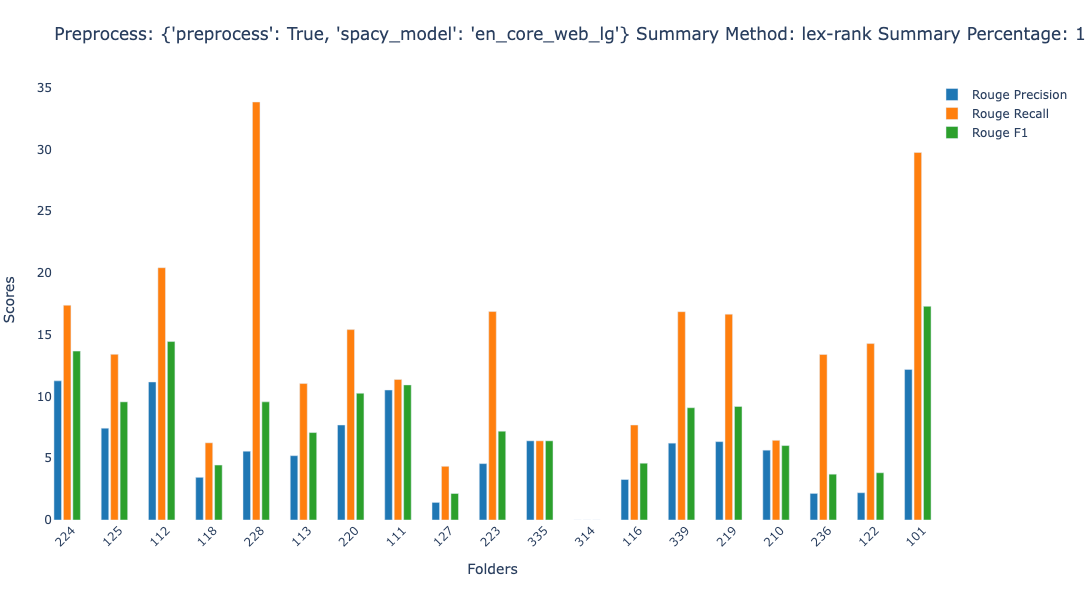

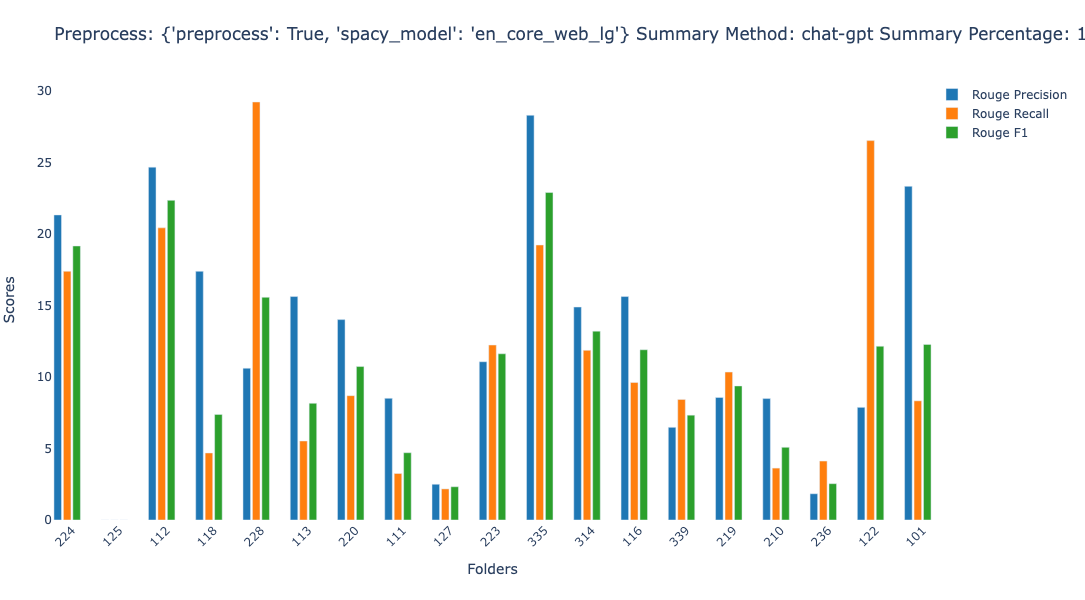

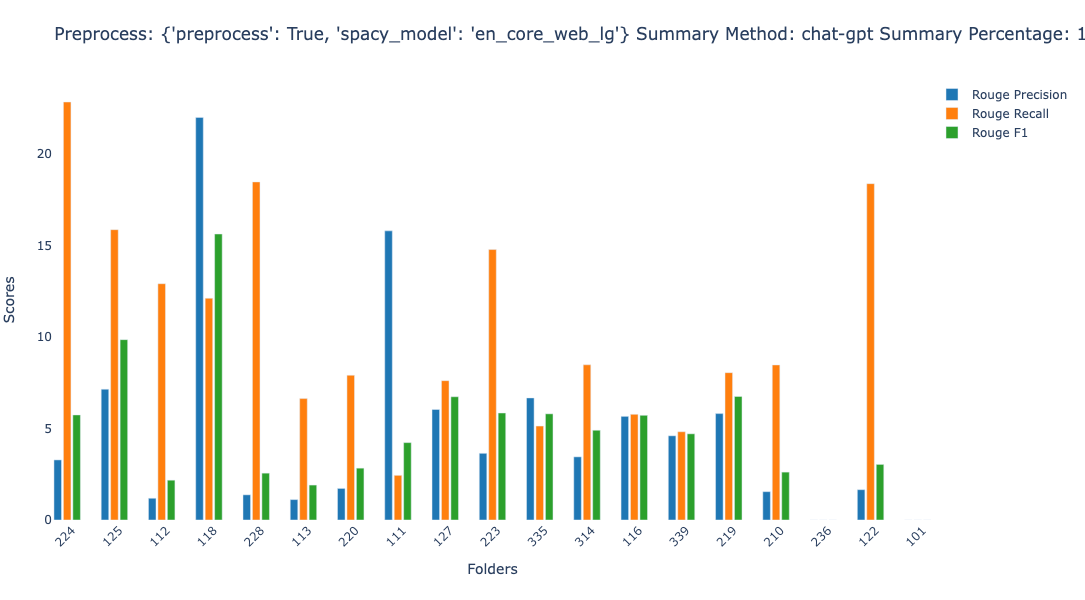

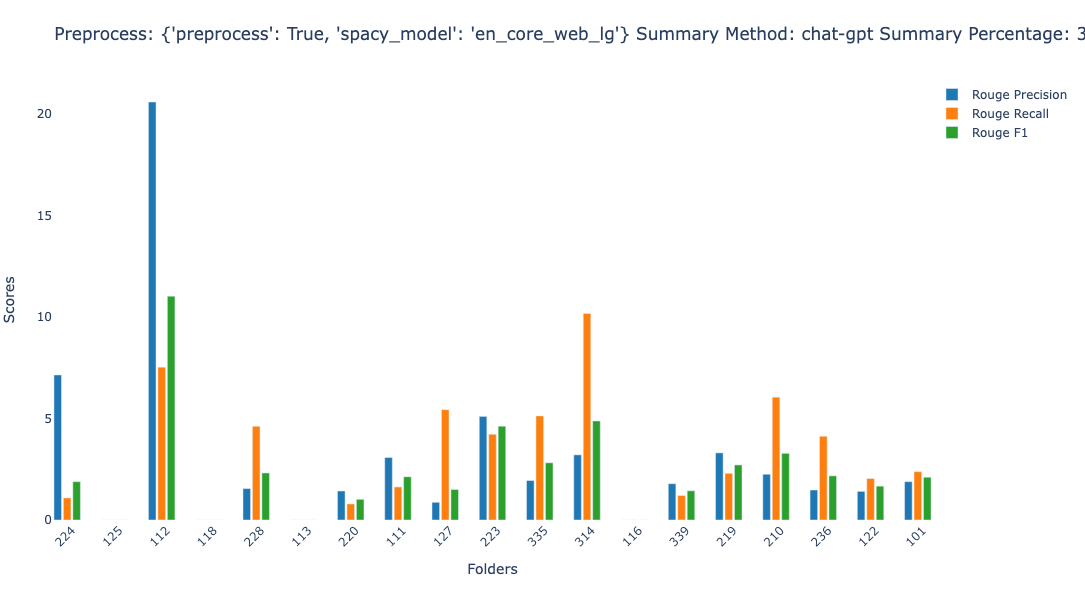

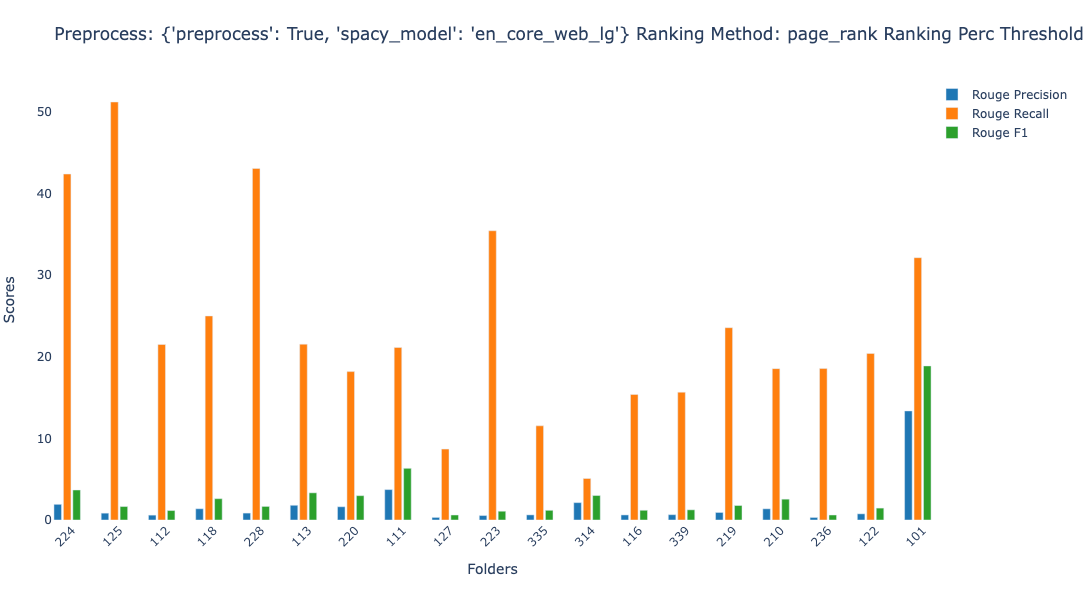

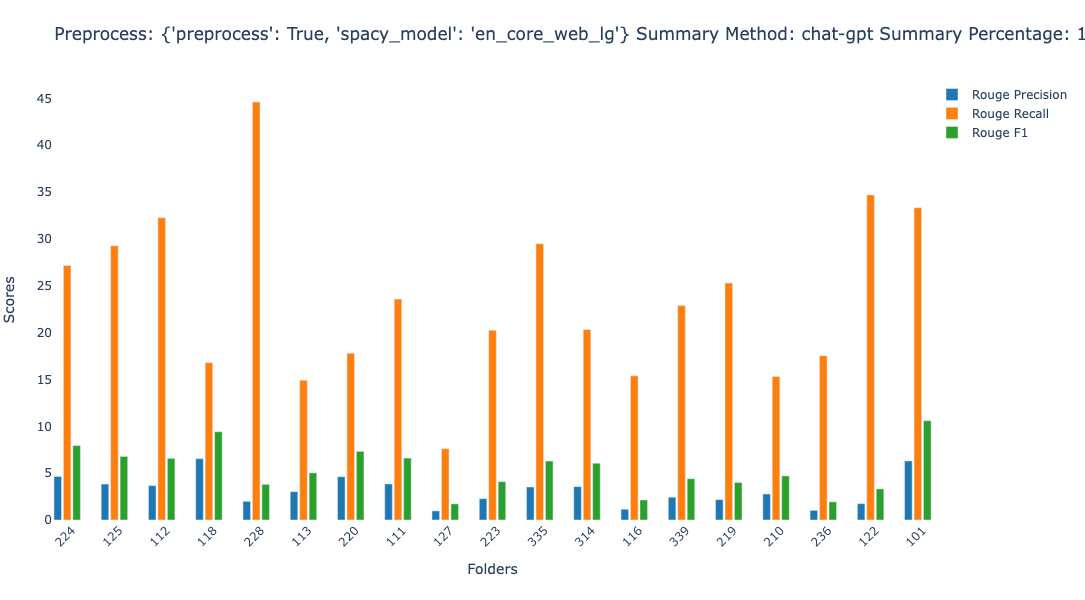

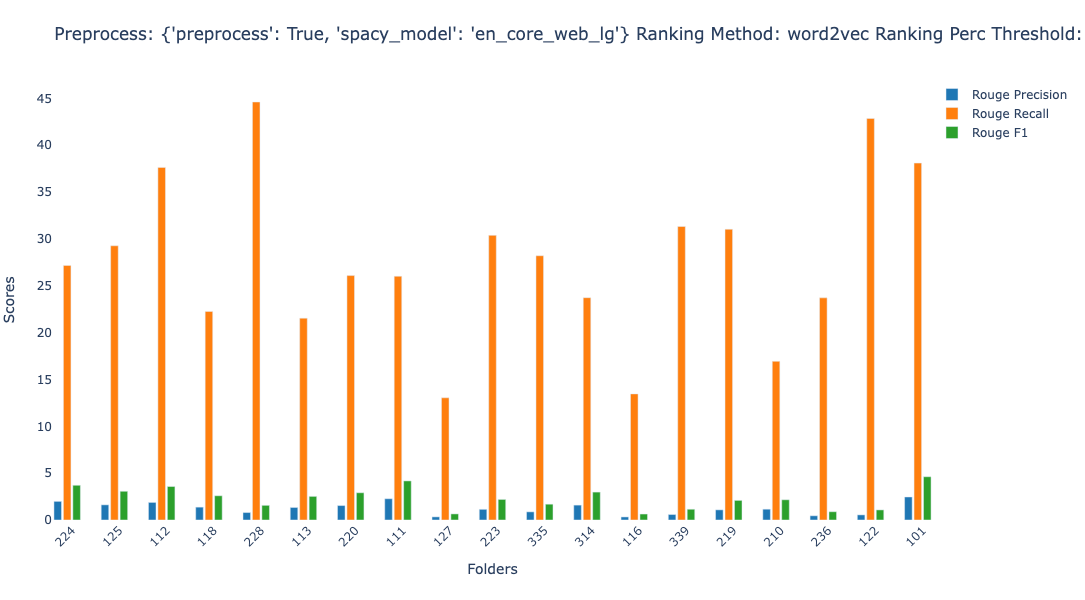

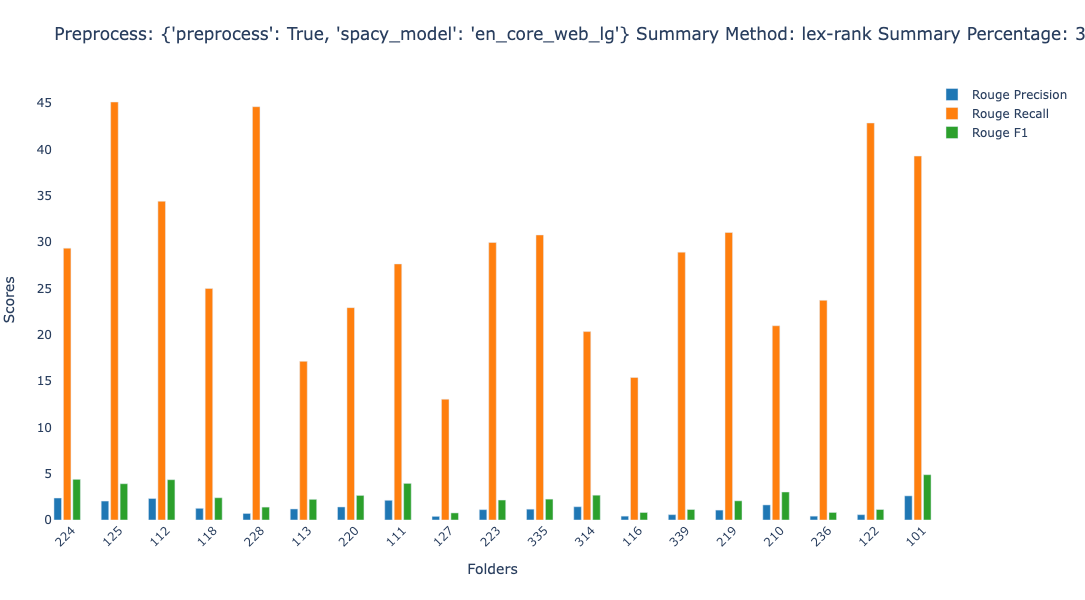

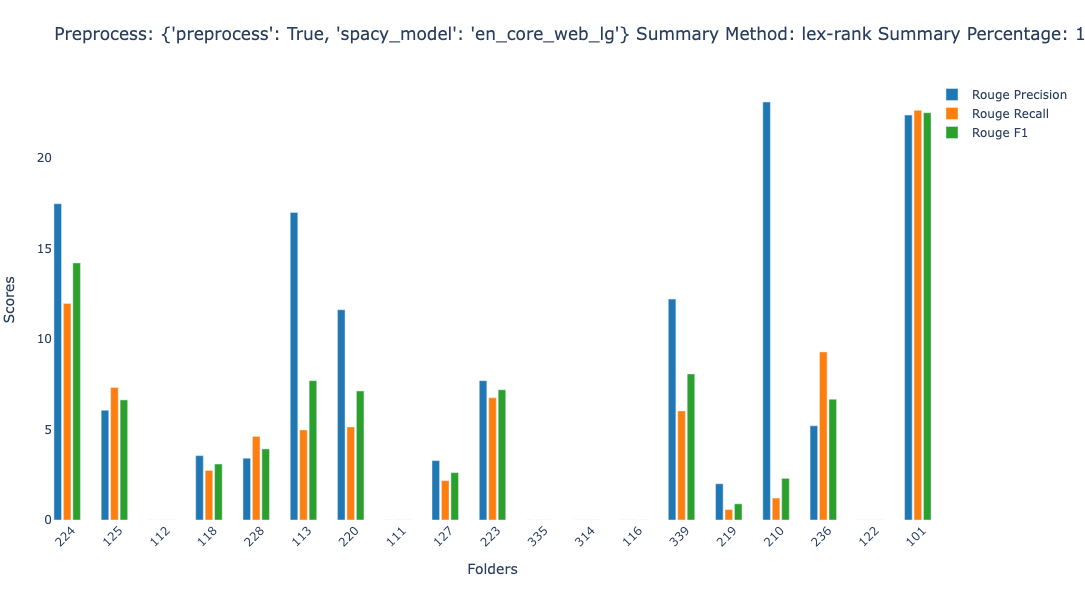

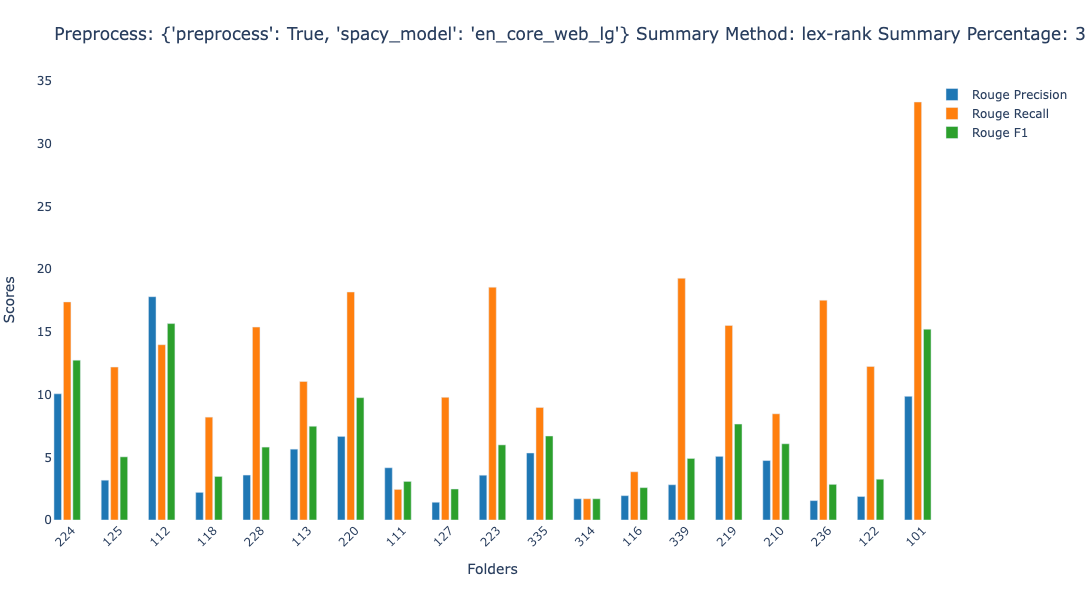

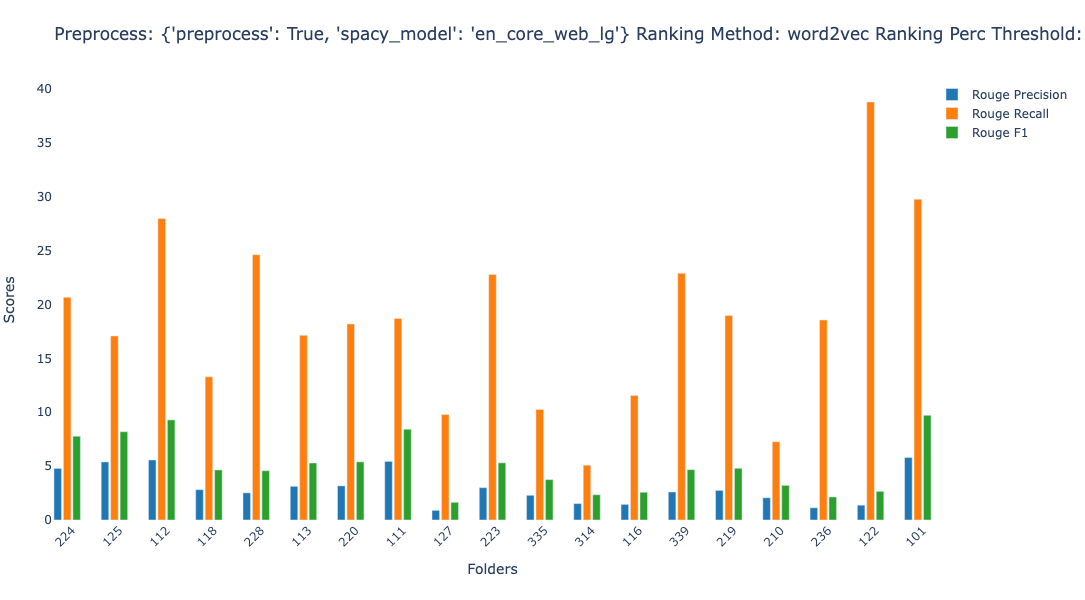

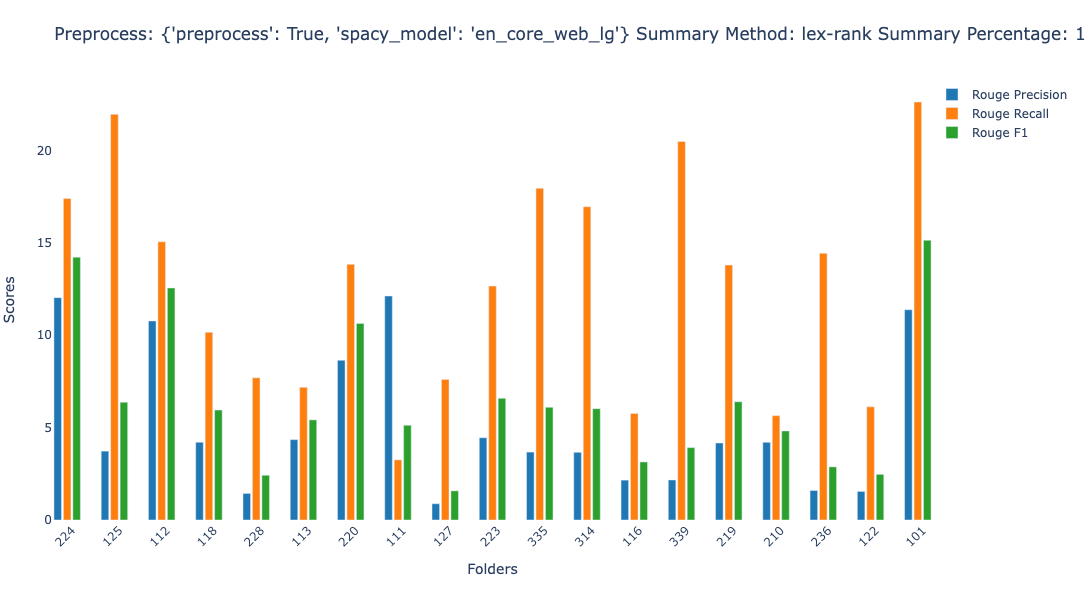

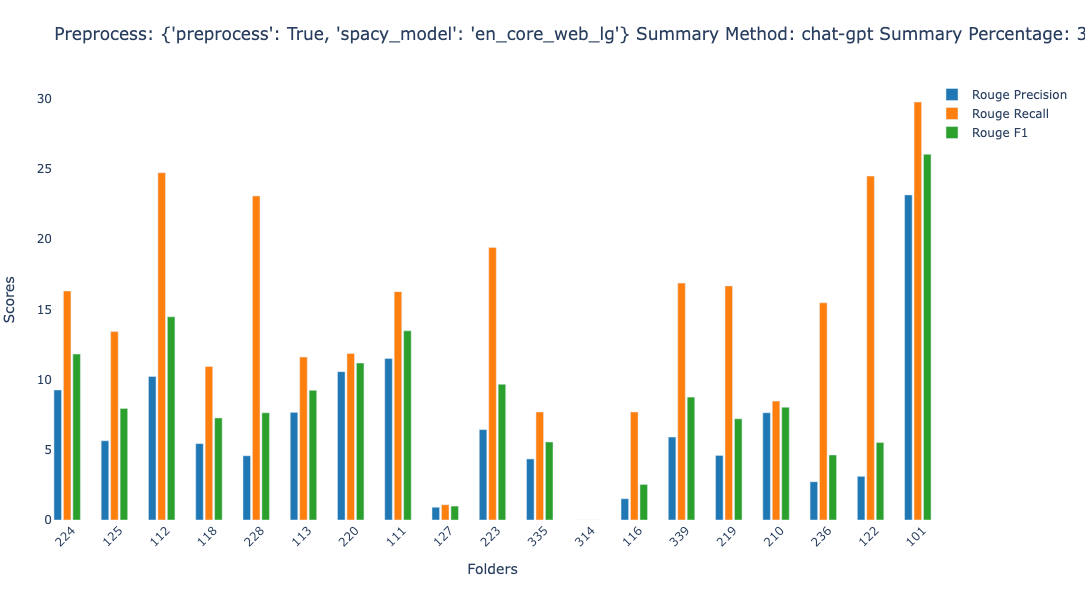

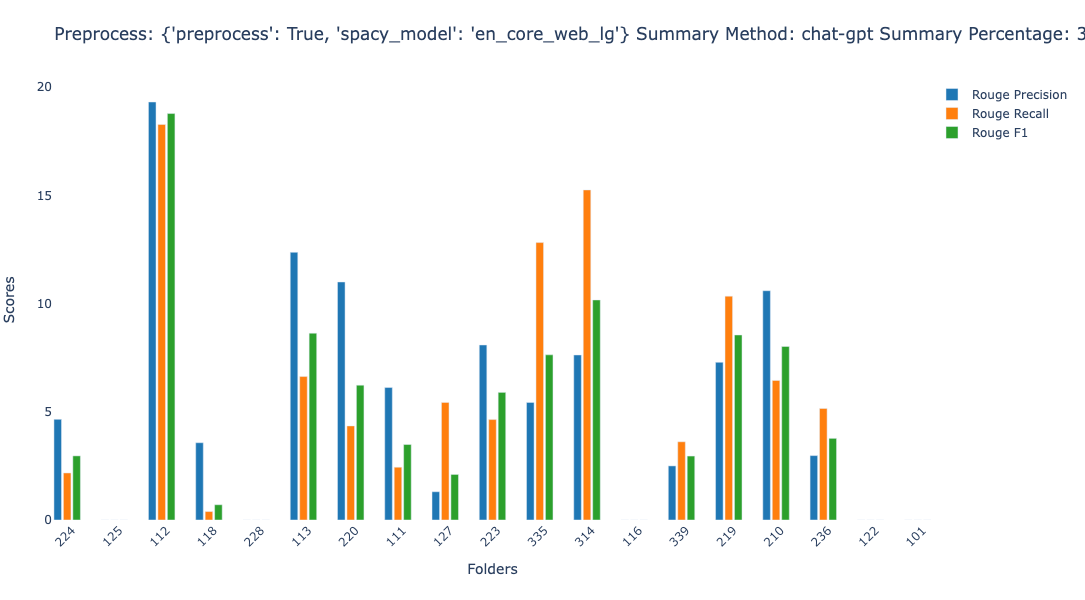

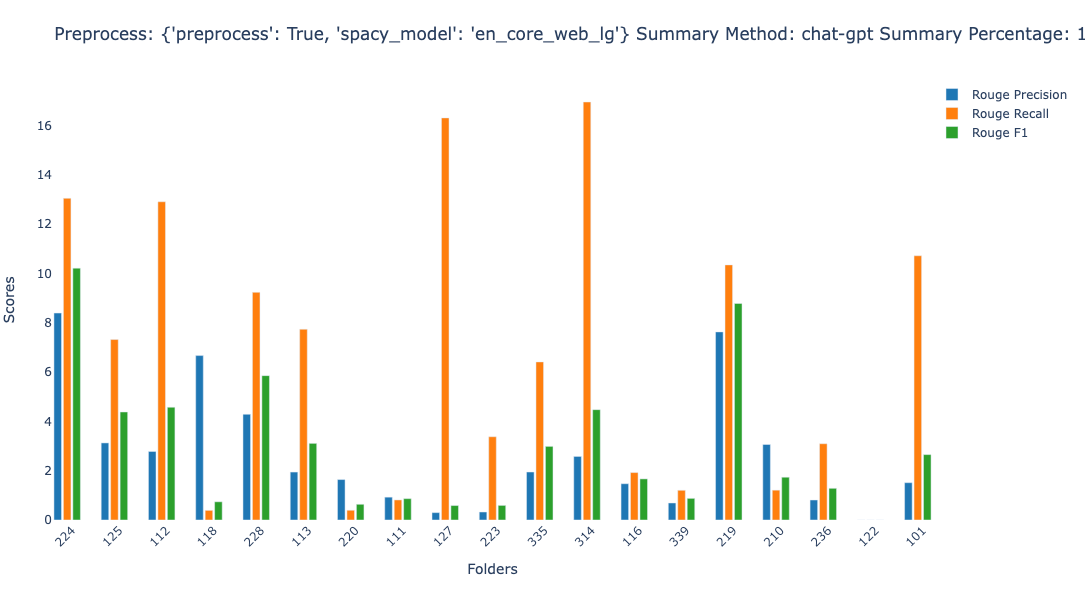

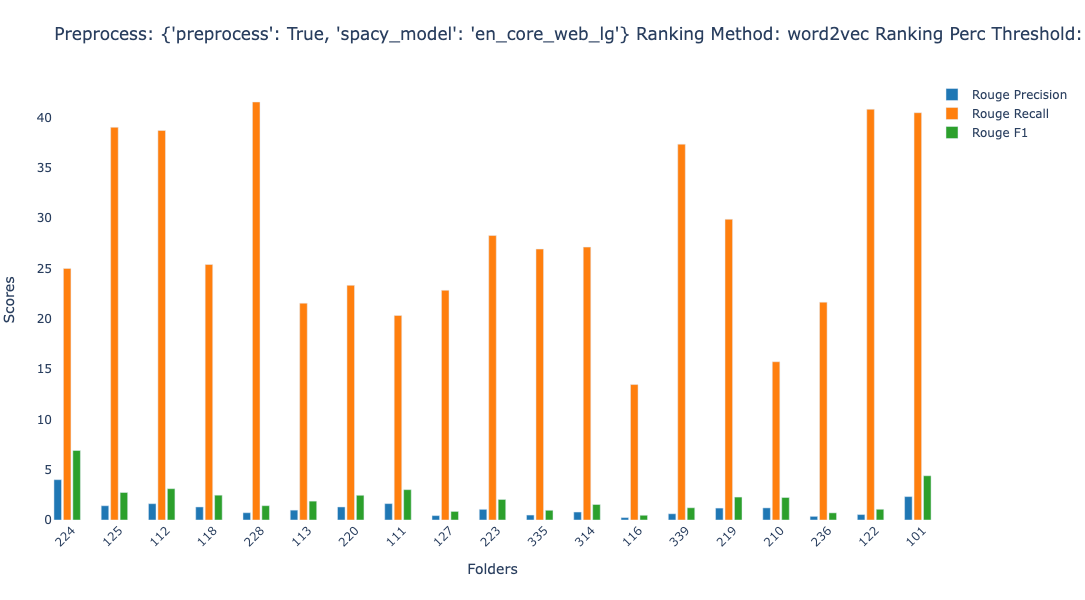

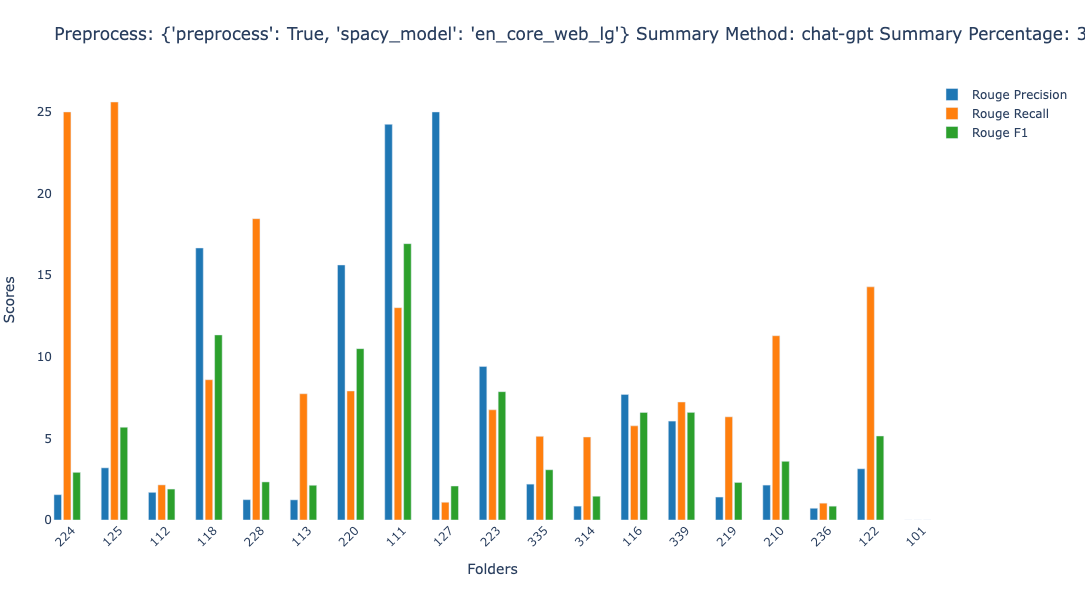

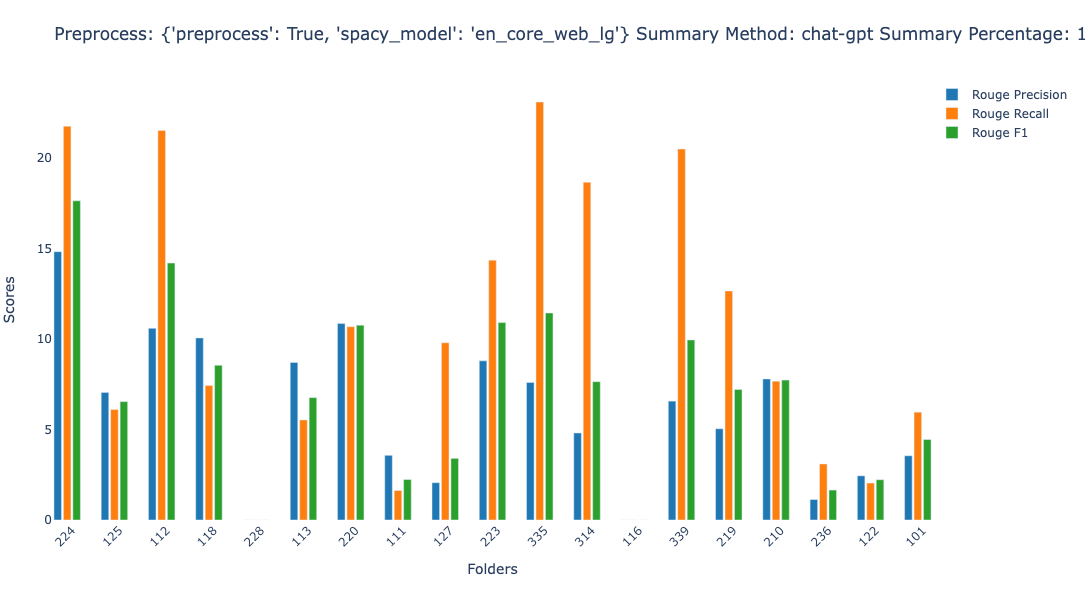

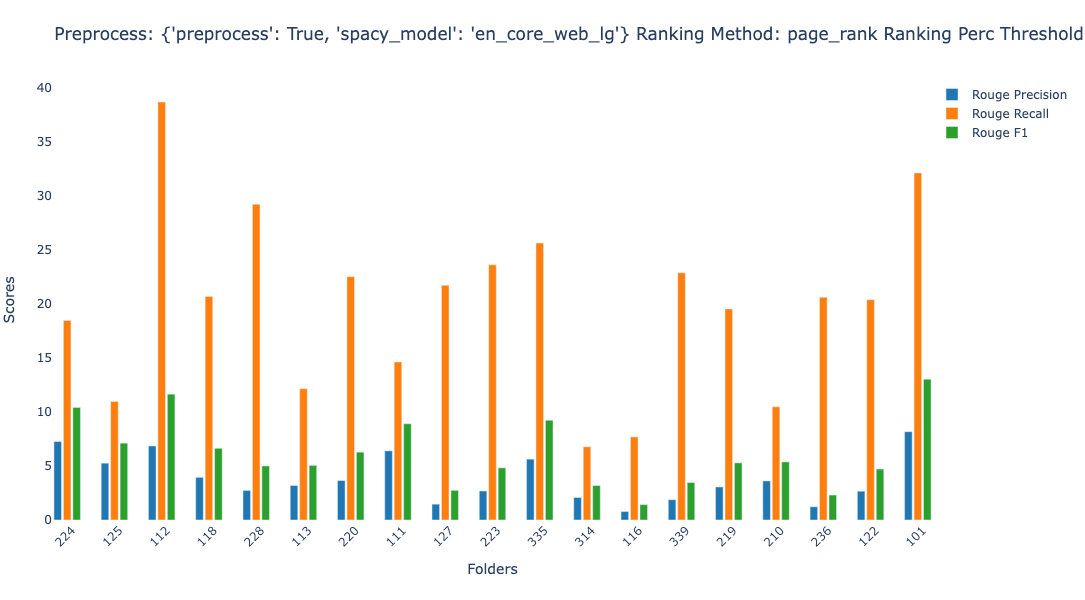

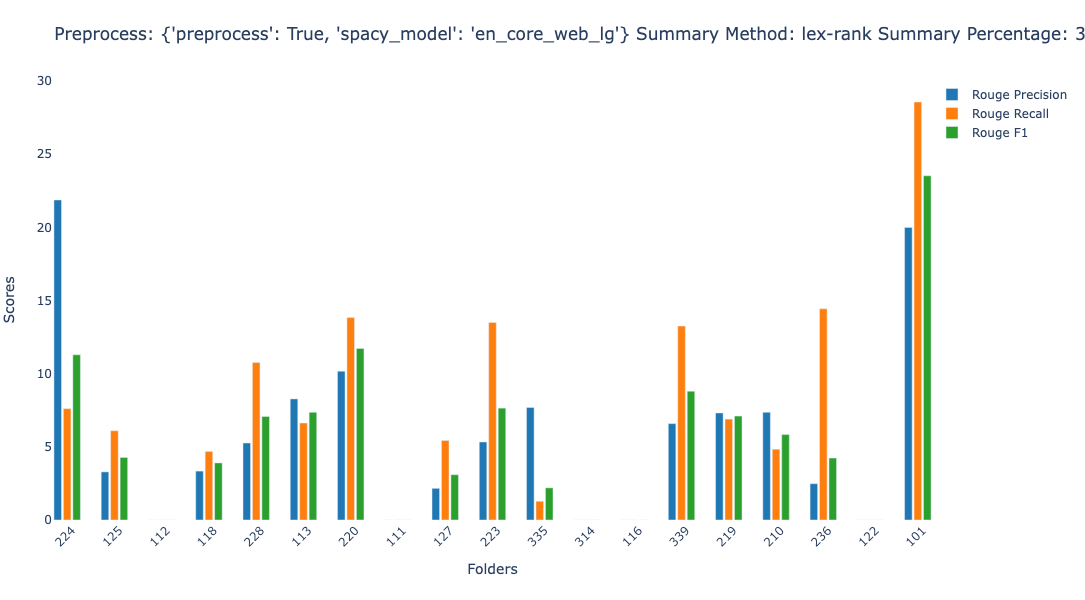

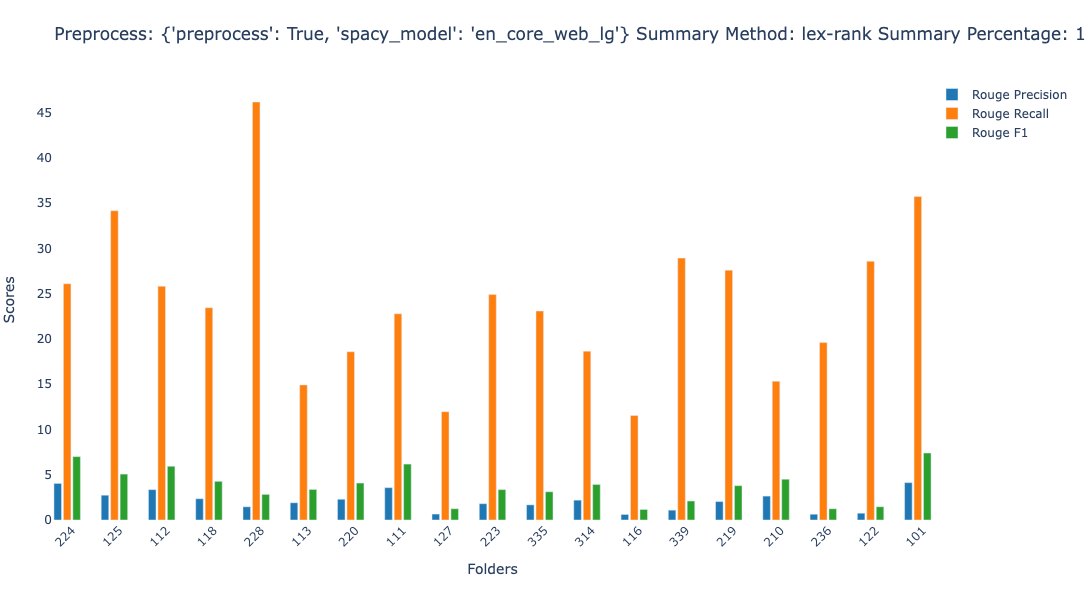

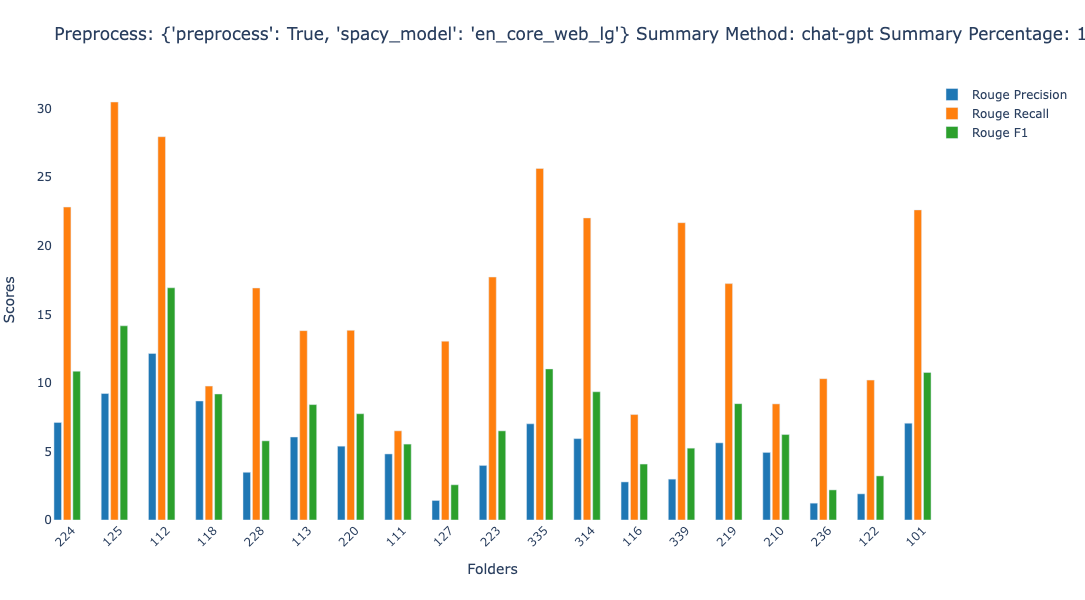

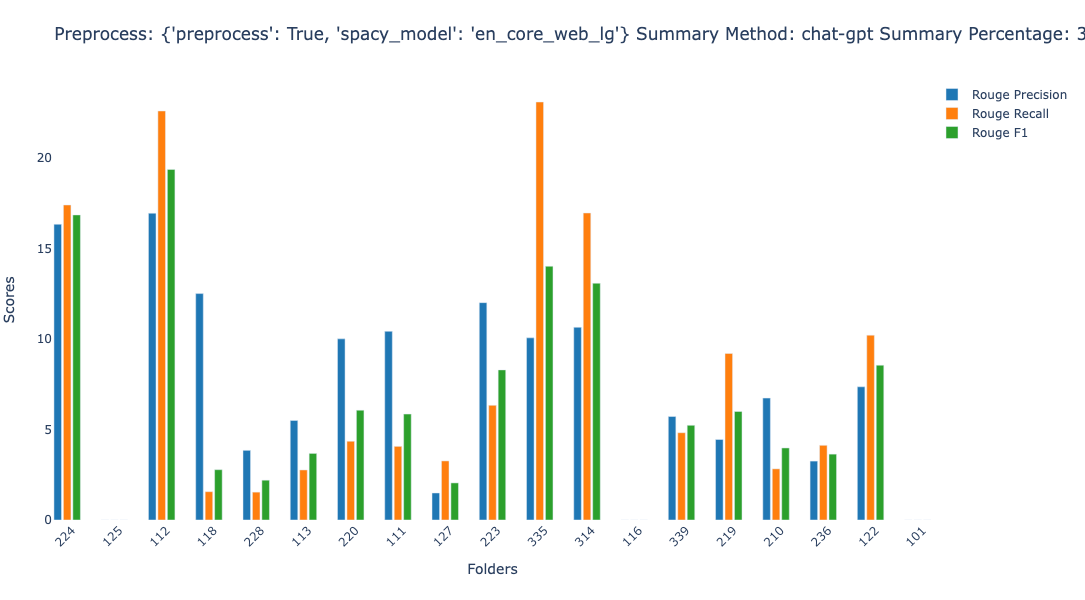

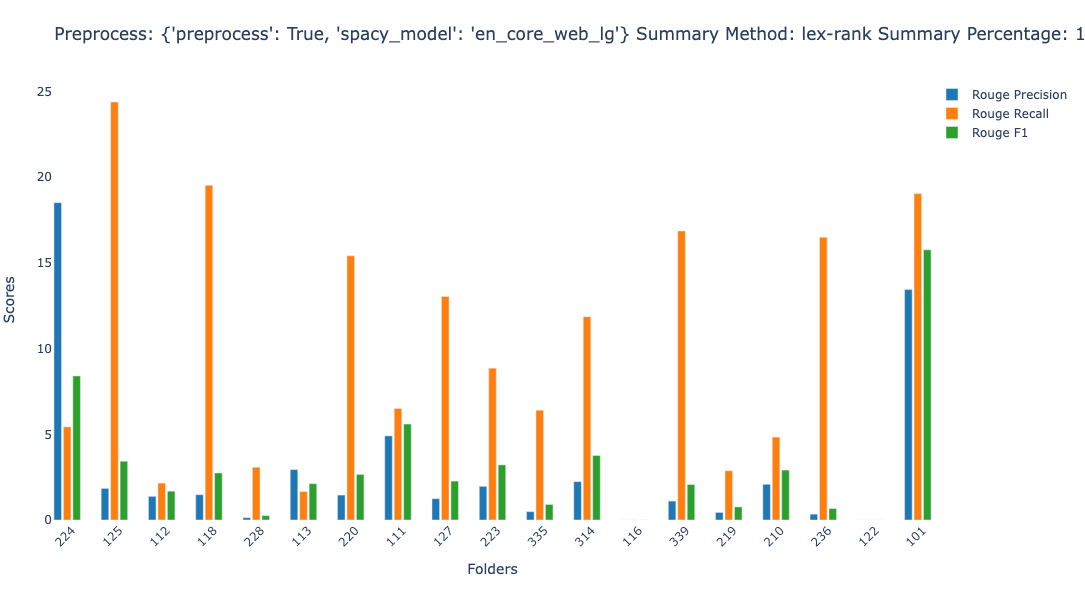

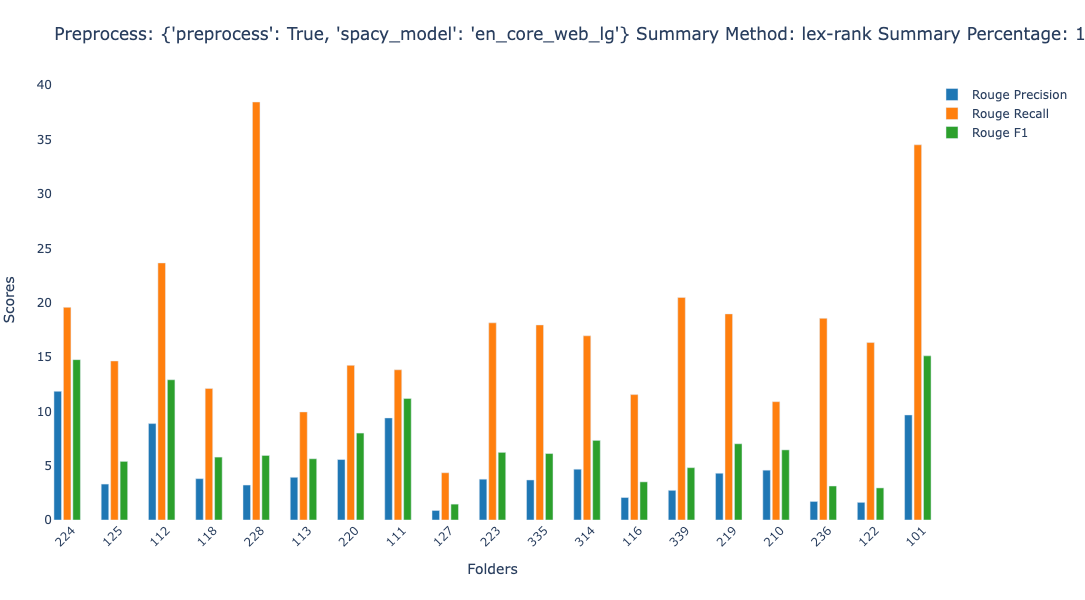

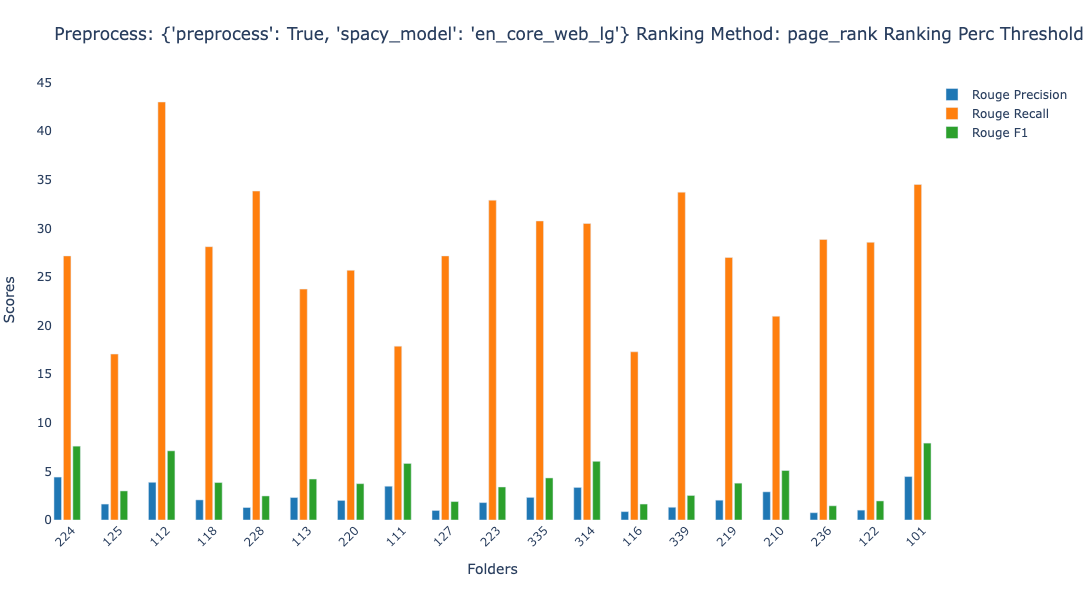

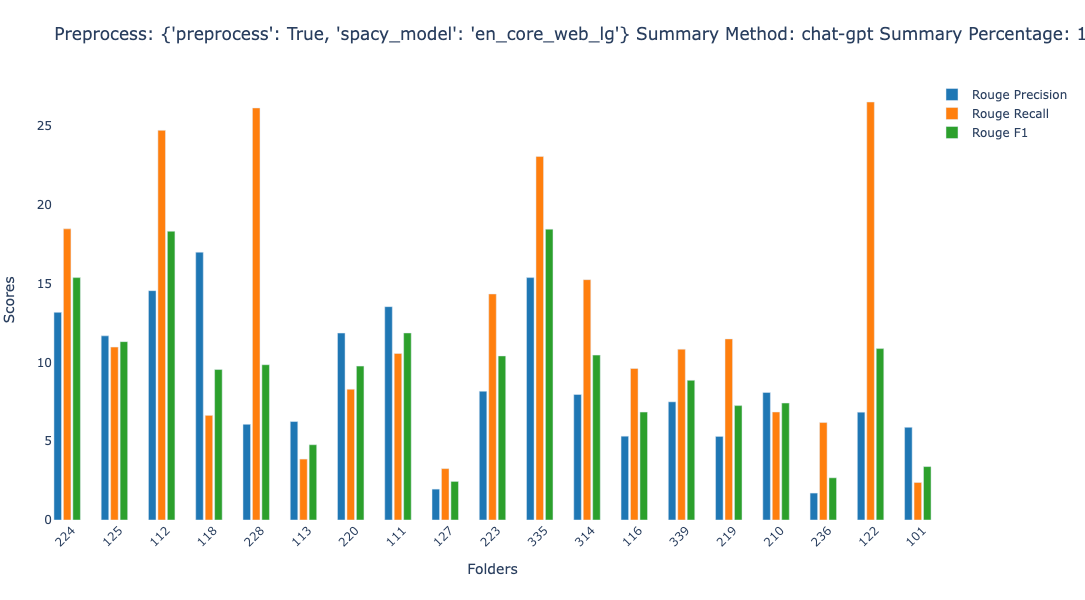

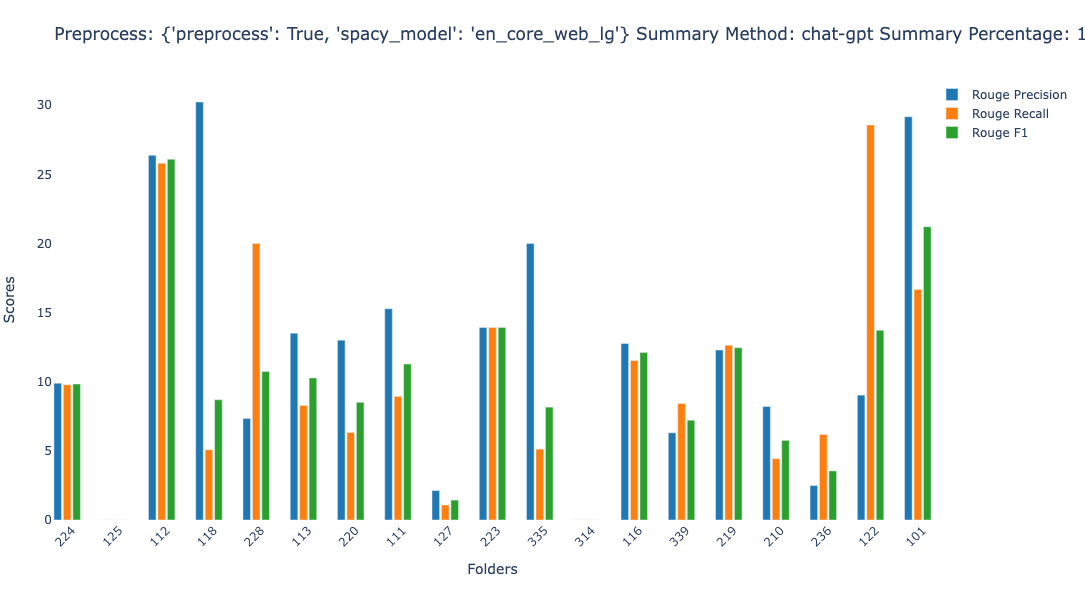

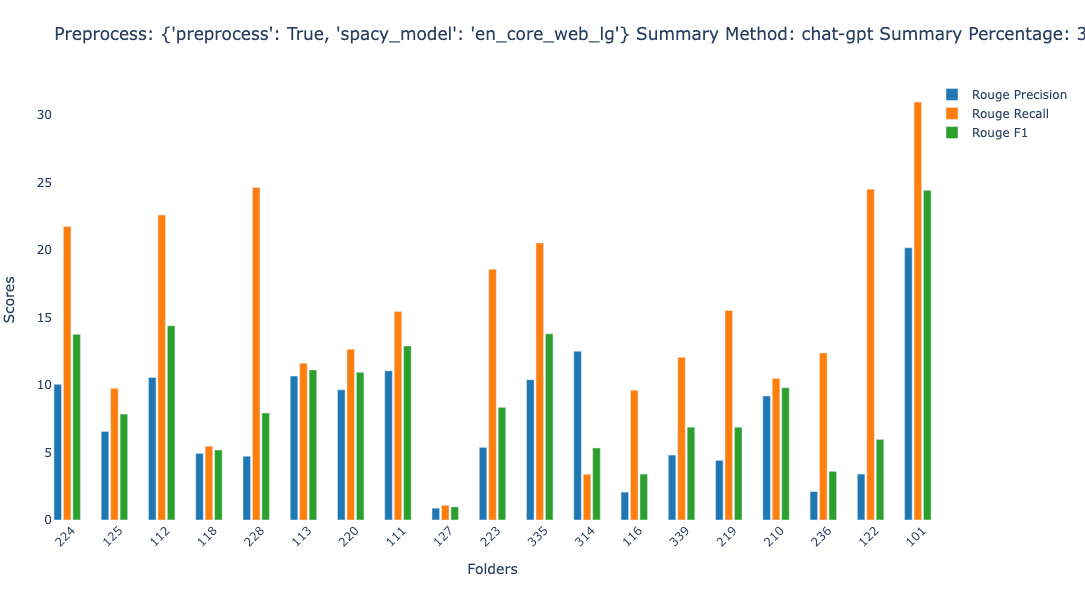

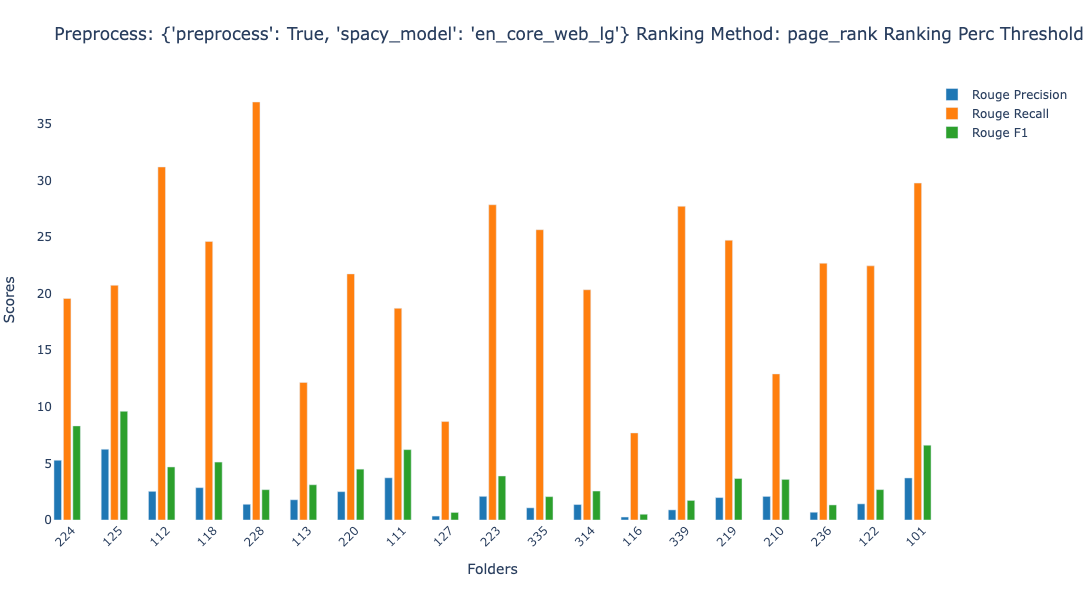

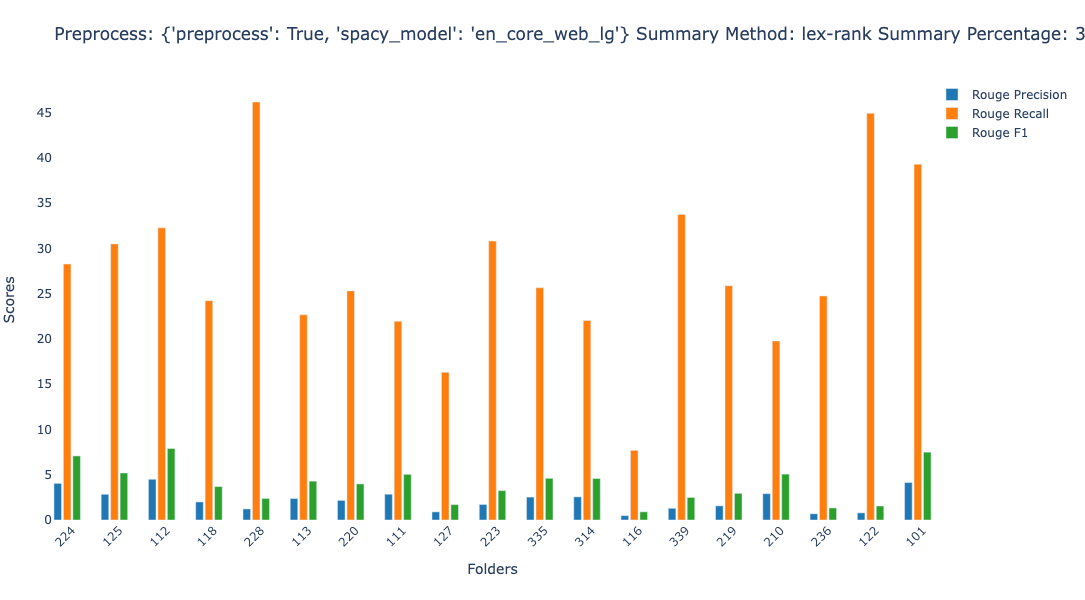

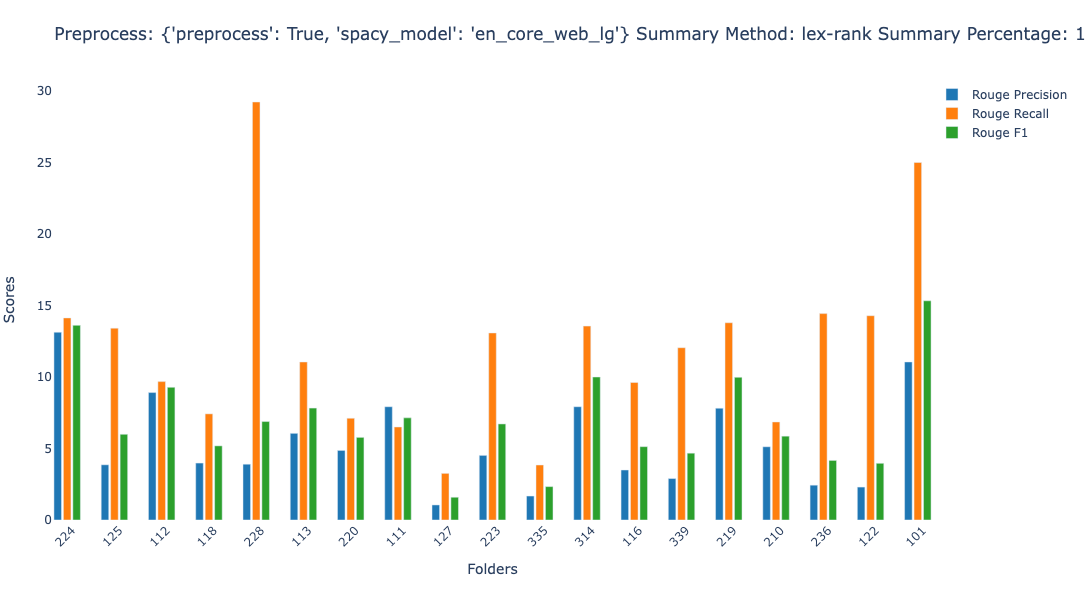

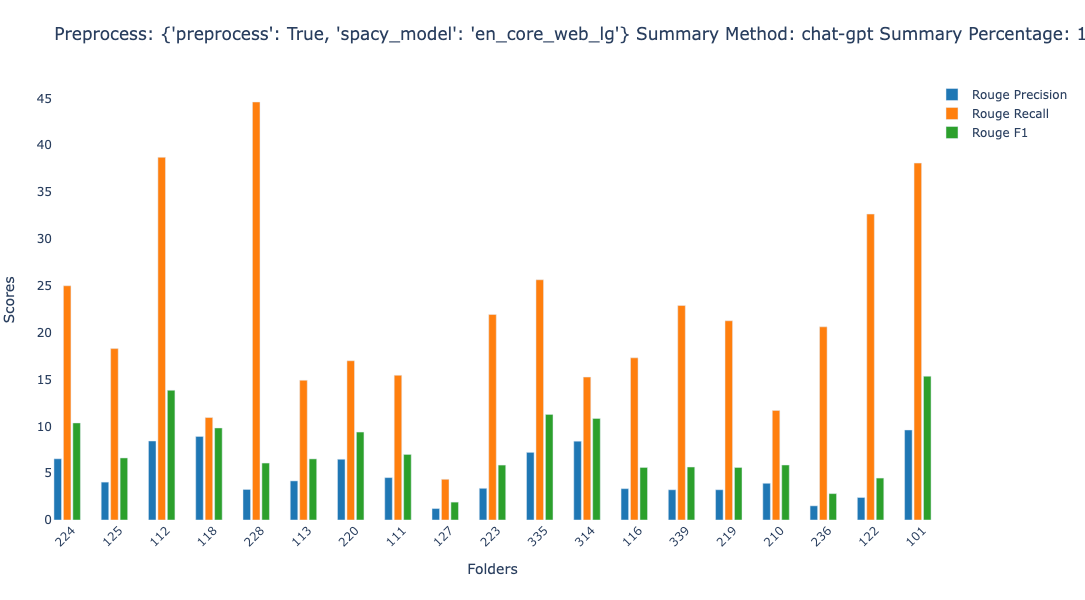

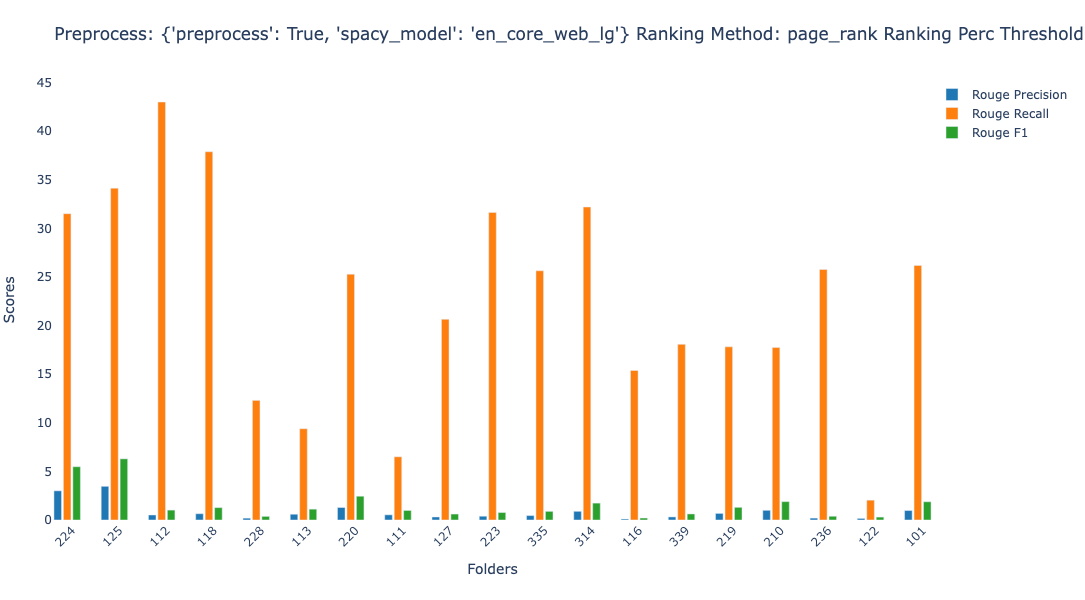

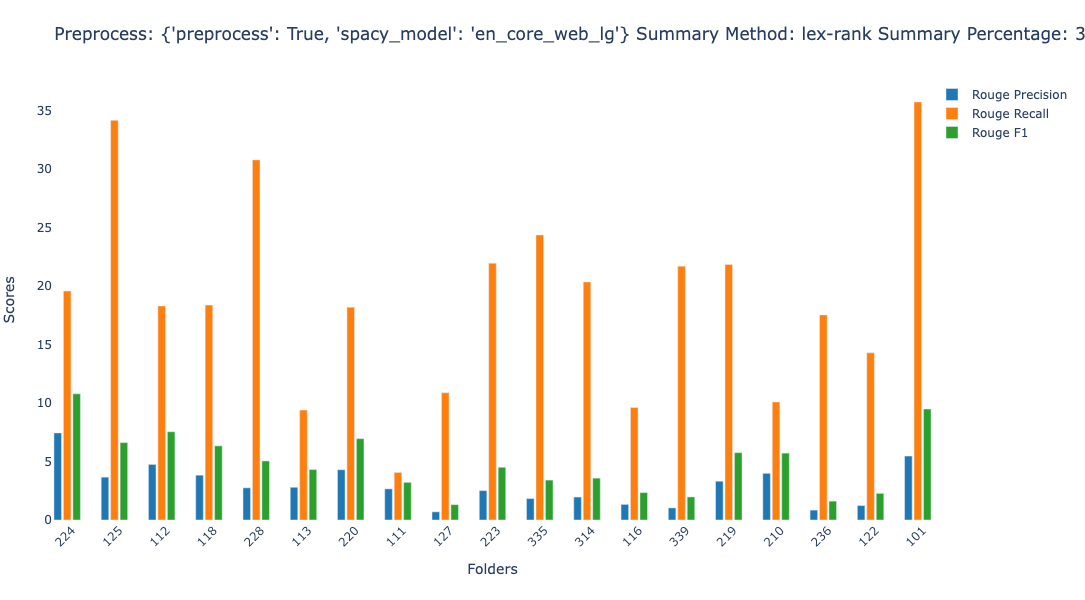

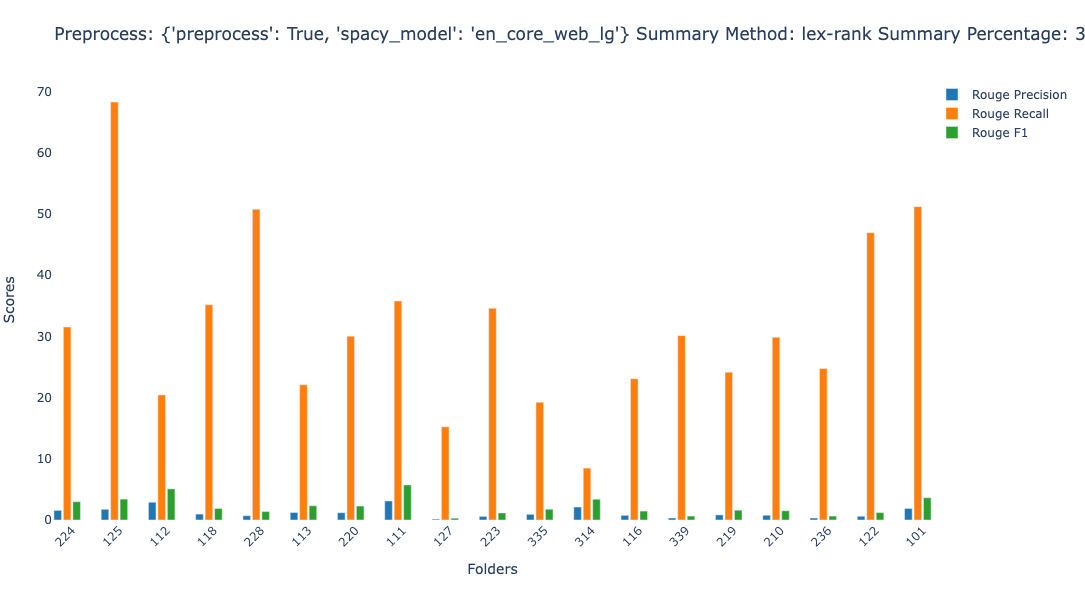

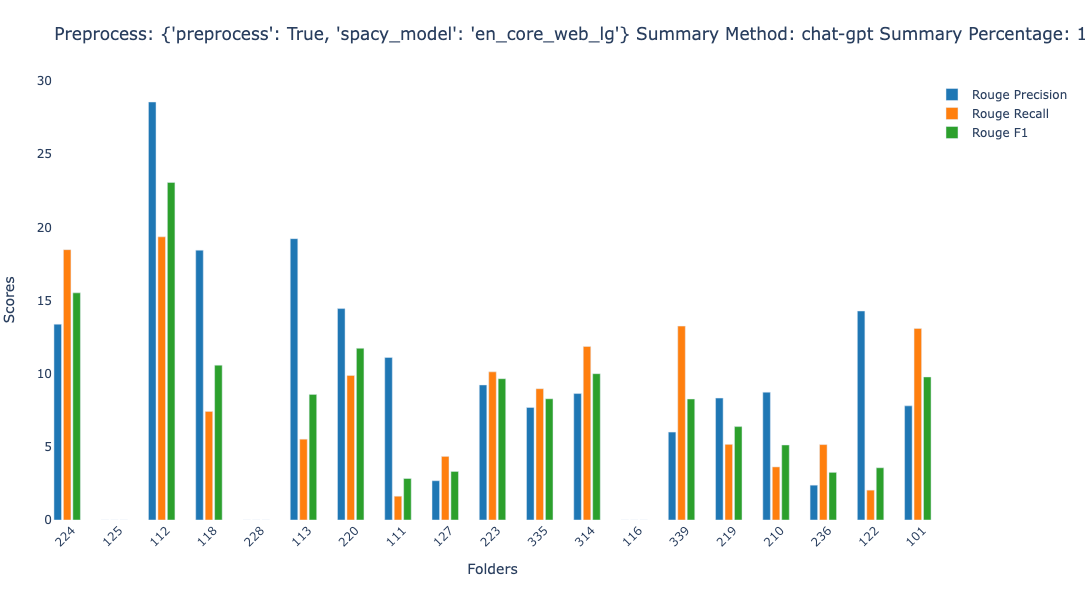

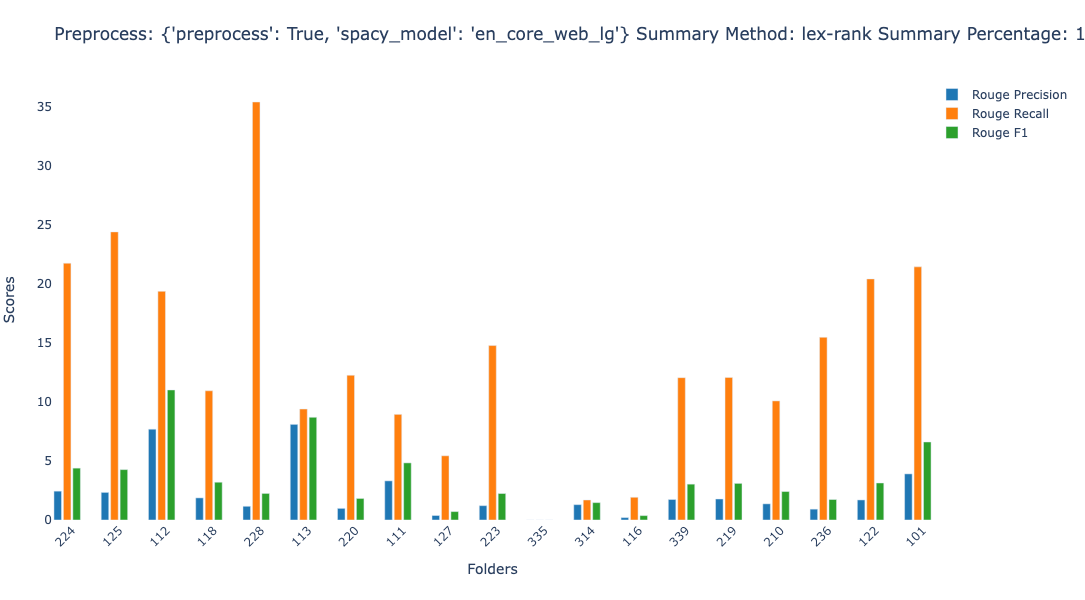

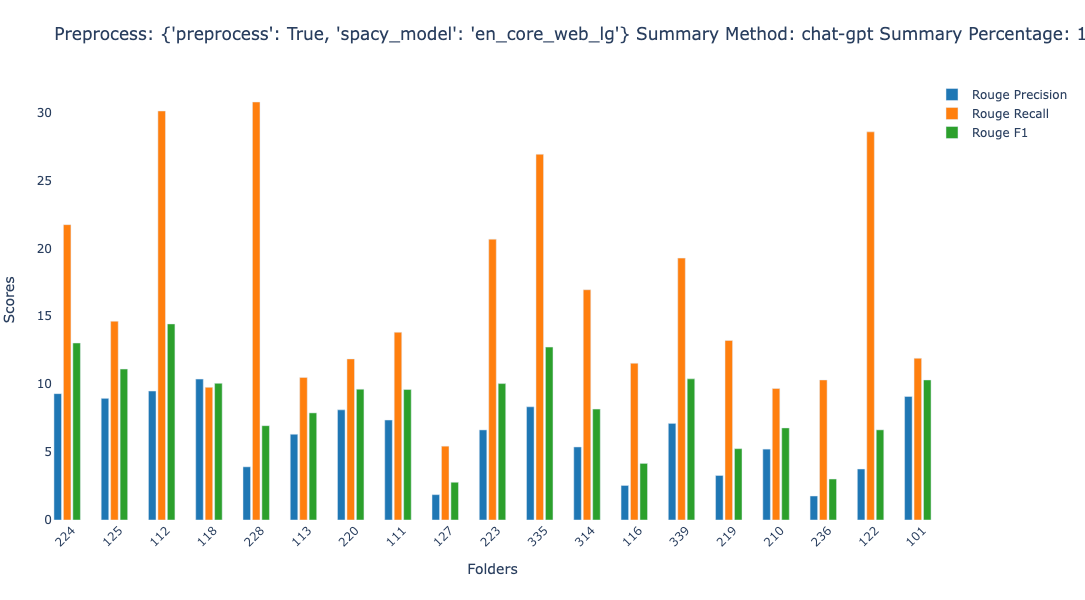

In [59]:
root_directory = "/Users/martina/Desktop/concept_map/experiments"
plotter = MetricsPlotter(root_directory)
plotter.plot_metrics_bar_directory()